## Imports

In [38]:
import fastai
from fastai.vision.all import *
from hyperdash import monitor_cell, Experiment

## Read Data

In [4]:
data_path = "/home/vconstan/projects/sTEC-d-dt-Anomaly-Detection/data/image_based/hawaii/"

In [5]:
dls = ImageDataLoaders.from_folder(
    data_path, 
    item_tfms=Resize(224),
    valid_pct=0.2,
    bs=512,
    ds_tfms=aug_transforms(do_flip=True, flip_vert=True)
)

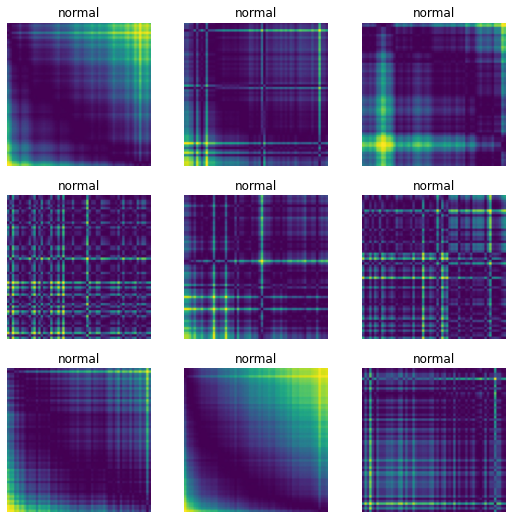

In [6]:
dls.show_batch()

In [7]:
dls.dataset

(#1012530) [(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1)),(PILImage mode=RGB size=360x360, TensorCategory(1))...]

In [10]:
# dls.dataset = dls.dataset.new(shuffle=False, sampler=ImbalancedDatasetSampler)

## Model Data

In [11]:
# define the learner 
learn = cnn_learner(
    dls, # data
    squeezenet1_1, # architecture 
    metrics=[error_rate, accuracy], # metrics
    pretrained=False, # whether or not to use transfer learning
    normalize=True, # this function adds a Normalization transform to the dls
#     callback_fns=[]
)

In [12]:
learn.show_training_loop()

Start Fit
   - before_fit     : [TrainEvalCallback, Recorder, ProgressCallback]
  Start Epoch Loop
     - before_epoch   : [Recorder, ProgressCallback]
    Start Train
       - before_train   : [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - before_batch   : []
         - after_pred     : []
         - after_loss     : []
         - before_backward: []
         - after_backward : []
         - after_step     : []
         - after_cancel_batch: []
         - after_batch    : [TrainEvalCallback, Recorder, ProgressCallback]
      End Batch Loop
    End Train
     - after_cancel_train: [Recorder]
     - after_train    : [Recorder, ProgressCallback]
    Start Valid
       - before_validate: [TrainEvalCallback, Recorder, ProgressCallback]
      Start Batch Loop
         - **CBs same as train batch**: []
      End Batch Loop
    End Valid
     - after_cancel_validate: [Recorder]
     - after_validate : [Recorder, ProgressCallback]
  End Epoch Loop
   - after_

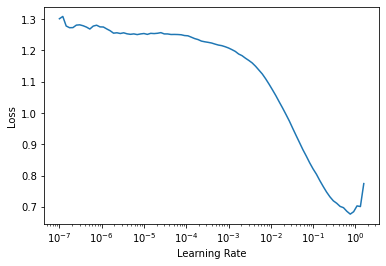

In [13]:
# find the minimum learning rate 
lr_min, lr_steep = learn.lr_find()

In [14]:
lr_min 

0.07585775852203369

In [15]:
lr = lr_min * 0.01
lr

0.0007585775852203369

In [16]:
# parallel GPUs!
if torch.cuda.device_count() > 1:
    learn.model = nn.DataParallel(learn.model)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.022267,0.030149,0.005452,0.994548,09:14
1,0.014946,0.026948,0.005859,0.994141,09:12
2,0.012788,0.086065,0.028819,0.971181,09:12
3,0.007768,0.010577,0.002631,0.997369,09:18
4,0.007600,0.008625,0.002236,0.997764,09:20
5,0.006617,0.008547,0.002287,0.997713,09:18
6,0.004252,0.007849,0.001584,0.998416,09:15
7,0.002855,0.004304,0.001011,0.998989,09:12
8,0.002984,0.005782,0.000936,0.999064,09:17
9,0.002097,0.003671,0.000924,0.999076,09:20


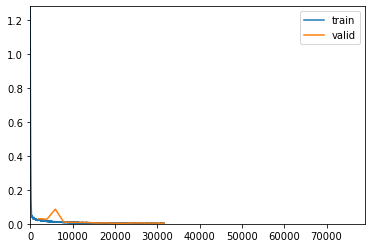

Better model found at epoch 0 with valid_loss value: 0.03014862909913063.
Better model found at epoch 1 with valid_loss value: 0.026947541162371635.
Better model found at epoch 3 with valid_loss value: 0.010576920583844185.
Better model found at epoch 4 with valid_loss value: 0.008624928072094917.
Better model found at epoch 5 with valid_loss value: 0.008547437377274036.
Epoch 6: reducing lr to 7.585775852203369e-05
Better model found at epoch 6 with valid_loss value: 0.007848902605473995.
Better model found at epoch 7 with valid_loss value: 0.004304291680455208.
Epoch 9: reducing lr to 7.58577585220337e-06
Better model found at epoch 9 with valid_loss value: 0.0036707394756376743.
Better model found at epoch 10 with valid_loss value: 0.0030716753099113703.
Epoch 12: reducing lr to 7.585775852203369e-07
Epoch 14: reducing lr to 7.58577585220337e-08
No improvement since epoch 10: early stopping


In [17]:
# Hyperdash API key: HaWsBsqUzqosfHQPw7XMSwl9l1gnGiUr05uydAzqxfo=

# Create an experiment with a model name, then autostart
exp = Experiment("Tsunami-related sTEC d/dt Anomaly Detection")

# set the parameters 
model = exp.param("model", squeezenet1_1)
lr = exp.param("learning_rate", lr)
# TODO: size training
# TODO: size validation 
# TODO: size holdout 
# TODO: holdout channels (ground station, satellite combinations)
# TODO: pretrained 
# TODO: normalize 
# TODO: callbacks 


# train the model 
learn.fit(
    40, 
    lr=lr,
    cbs=[
        ShowGraphCallback(),
        CSVLogger(),
#         ParamScheduler(sched),
        ReduceLROnPlateau(
            monitor='valid_loss', 
            min_delta=0.001, 
            patience=2
        ),
        EarlyStoppingCallback(
            monitor="valid_loss",
            patience=5,
            min_delta=0.0005
        ),
        SaveModelCallback()
    ]
) 


# record metrics 
# TODO: accuracy = exp.metric("accuracy", classifer.score(X_test, y_test))
# TODO: recall 
# TODO: precision 
# TODO: F-score 
# TODO: coverage 
# TODO: holdout recall, precision, accuracy, f-score, coverage as well 
# TODO: total training time 
# TODO: train loss, valid loss, error rate 

# end the experiment 
# TODO: in future move experiment end to include additional validation, experimentation 
exp.end()

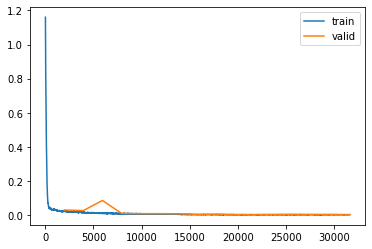

In [18]:

# plot the loss curve from model training
learn.recorder.plot_loss()

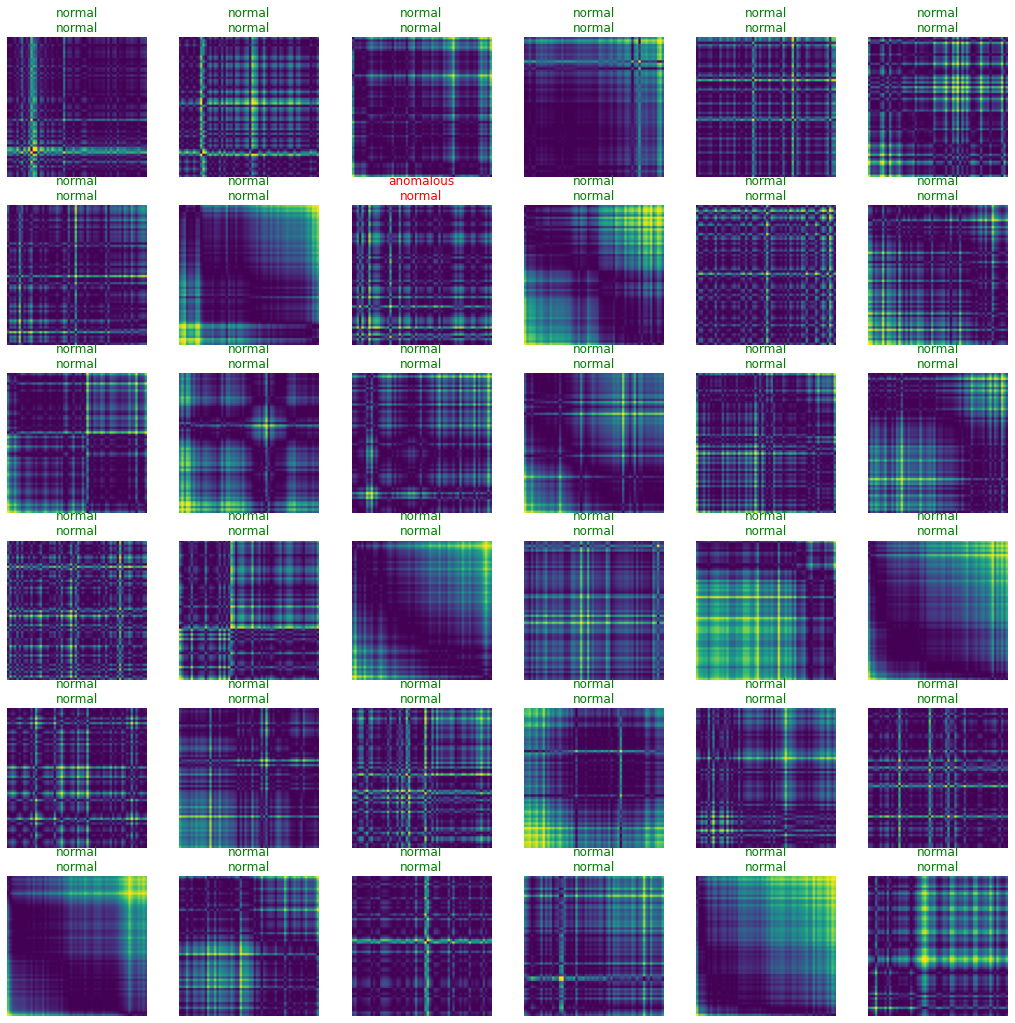

In [36]:
learn.show_results(max_n=36)

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

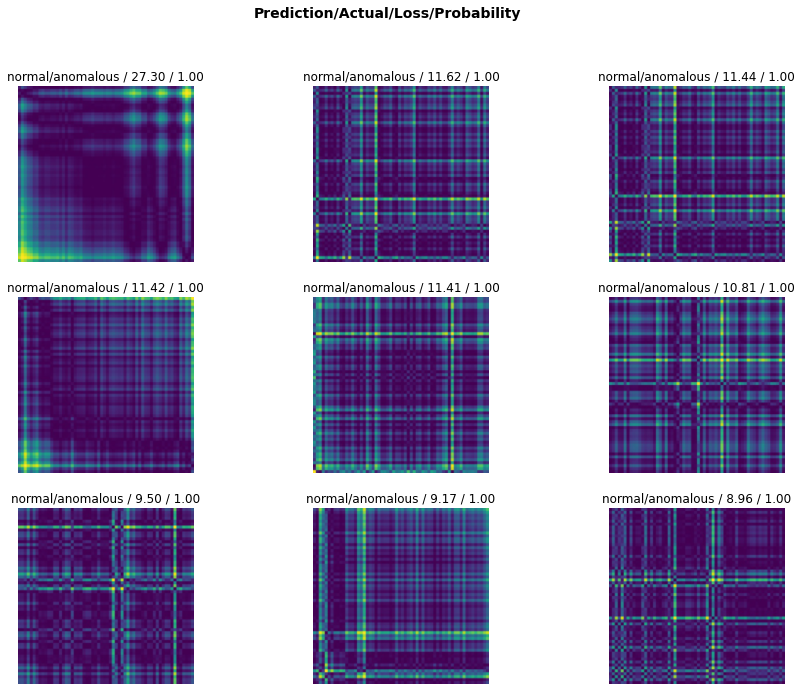

In [21]:
interp.plot_top_losses(9, figsize=(15,11))

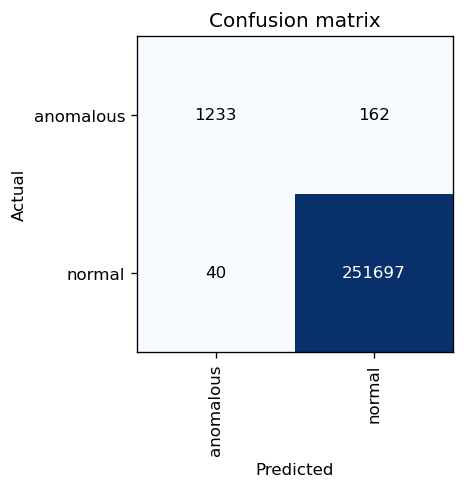

In [22]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=120)

In [32]:
# TODO: from confusion matrix, generate anomalous and normal recall, precision, F-Scores. 